<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/Faster_RCNN_%EC%97%B0%EC%8A%B5%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Faster R-CNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/object-detection/Ch5-Faster-R-CNN.ipynb)

In [7]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1 데이터 불러오기


In [8]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


## 2 데이터 분리


In [9]:
!jar xvf Faster_RCNN_test_data.zip

java.io.FileNotFoundException: Faster_RCNN_test_data.zip (No such file or directory)
	at java.base/java.io.FileInputStream.open0(Native Method)
	at java.base/java.io.FileInputStream.open(FileInputStream.java:219)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:157)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:112)
	at jdk.jartool/sun.tools.jar.Main.run(Main.java:407)
	at jdk.jartool/sun.tools.jar.Main.main(Main.java:1680)


In [11]:
!mv /content/Face\ Mask\ Detection/annotations /content/
!mv /content/Face\ Mask\ Detection/images /content/

In [12]:
import os
import random
import numpy as np
import shutil

print('총 데이터 갯수 ( annotation / images )')
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(151), 25)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print('train 데이터 갯수')
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

print('test 데이터 갯수')
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

총 데이터 갯수 ( annotation / images )
151
151
train 데이터 갯수
126
126
test 데이터 갯수
25
25


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## 3 데이터셋 클래스 정의

In [15]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [16]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 4 모델 불러오기

In [17]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5 전이 학습


In [18]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
torch.cuda.is_available()

True

In [20]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [21]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 21.464763641357422, time : 48.18744087219238
epoch : 2, Loss : 14.210145950317383, time : 43.591302156448364
epoch : 3, Loss : 10.757451057434082, time : 46.83268976211548
epoch : 4, Loss : 8.413383483886719, time : 47.30577087402344
epoch : 5, Loss : 8.510653495788574, time : 47.21852517127991
epoch : 6, Loss : 8.319680213928223, time : 47.097885608673096
epoch : 7, Loss : 6.790060520172119, time : 47.327934980392456
epoch : 8, Loss : 6.380255699157715, time : 47.476935386657715
epoch : 9, Loss : 5.9661970138549805, time : 47.36218595504761
epoch : 10, Loss : 5.984827995300293, time : 47.16353797912598


In [22]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [23]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## 6 예측


In [25]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [26]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[197.4331,  63.0072, 215.1507,  94.0616],
        [ 21.1431,  69.4487,  41.9562,  92.9320],
        [319.4340,  28.6719, 351.0931,  70.4606],
        [226.1645,  36.1994, 259.6963,  73.7770],
        [144.3547,  66.3092, 171.9173, 111.8049],
        [368.8846,  68.0799, 386.8632,  98.8719],
        [ 81.9938,  55.1593, 111.2258,  89.9959],
        [298.9461,  55.5012, 313.0807,  80.9923]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 1, 2], device='cuda:0'), 'scores': tensor([0.9939, 0.9849, 0.9674, 0.9623, 0.9575, 0.8601, 0.7518, 0.6019],
       device='cuda:0')}, {'boxes': tensor([[188.8533,  19.6836, 242.6360,  84.3484],
        [122.7219,  81.0413, 163.8347, 125.0180],
        [389.3249,  49.8941, 400.0000,  76.6386]], device='cuda:0'), 'labels': tensor([2, 2, 2], device='cuda:0'), 'scores': tensor([0.9816, 0.9428, 0.8665], device='cuda:0')}]


Target :  tensor([2, 2, 2])


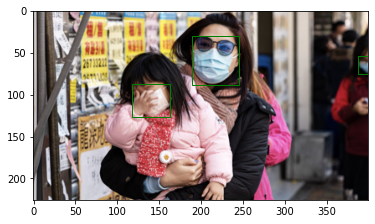

Prediction :  tensor([2, 2, 2], device='cuda:0')


TypeError: ignored

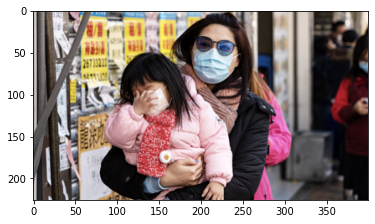

In [27]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

In [28]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


In [29]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [30]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5406480331543572
AP : tensor([0.8277, 0.7942, 0.0000], dtype=torch.float64)
